# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.mean(np.square(y_true - y_predicted))

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    rss = sum(np.square(y_true - y_predicted))
    tss = sum(np.square(y_true - np.mean(y_true)))
    return 1 - rss / tss

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [11]:
class NormalLR:
    def __init__(self):
        self.w = None
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X_ = np.hstack((np.ones((X.shape[0], 1)), X))
        self.w = np.linalg.inv(X_.T @ X_) @ X_.T @ y
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        X_ = np.hstack((np.ones((X.shape[0], 1)), X))
        return X_ @ self.w

In [12]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [13]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009077361058275618, R2: 0.9969602533378904


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с learning rate `alpha` в течение `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [134]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.w = None
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X = X.copy()
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        def grad(w):
            return 1 / X.shape[0] * X.T @ (X @ w - y) + self.l * np.sign(w)
        
        def gradient_descent(x, max_iter=10000, tol=1e-8):
            start_grad = np.linalg.norm(grad(x)) ** 2
            for _ in range(max_iter):
                g = grad(x)
                if np.linalg.norm(g) ** 2 / start_grad < tol:
                    break
                d = -g
                x = x + self.alpha * d
            return x
        
    
        self.w = gradient_descent(np.array([1 for _ in range(X.shape[1])]), max_iter=self.iterations)


    def predict(self, X:np.ndarray):
        X = X.copy()
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X @ self.w
    
    @property
    def coef_(self):
        return self.w[1:]
    
    @property
    def intercept_(self):
        return self.w[0]

In [103]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.xlabel("Коэффициент регуляризации")
    plt.ylabel("MSE")
    plt.show()

In [104]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

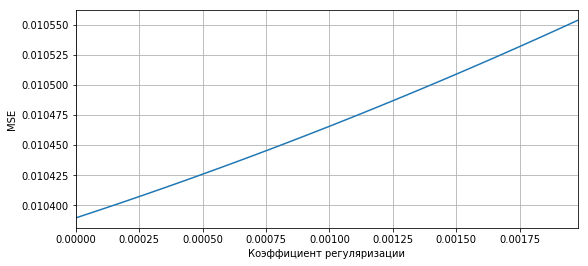

In [105]:
build_plot(X_train, y_train, X_val, y_val)

In [106]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010623679209131955, R2: 0.9985263268229801


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [107]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [108]:
def normalise(X_train, X_test, y_train, y_test):
    maxs = np.amax(X_train, axis=0)
    mins = np.amin(X_train, axis=0)
    y_max, y_min = np.max(y_train), np.min(y_train)
    for j in range(X_train.shape[1]):
        for i in range(X_train.shape[0]):
            X_train[i][j] = (X_train[i][j] - mins[j]) / (maxs[j] - mins[j])
    for j in range(X_test.shape[1]):
        for i in range(X_test.shape[0]):
            X_test[i][j] = (X_test[i][j] - mins[j]) / (maxs[j] - mins[j])
    
    for i in range(y_train.shape[0]):
        y_train[i] = (y_train[i] - y_min) / (y_max - y_min)
    for i in range(y_test.shape[0]):
        y_test[i] = (y_test[i] - y_min) / (y_max - y_min)
    
    return X_train, X_test, y_train, y_test

In [109]:
X_train, X_val, y_train, y_val = normalise(X_train, X_val, y_train, y_val)

In [110]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 0.010995709175721886, R2: 0.6872797475661063


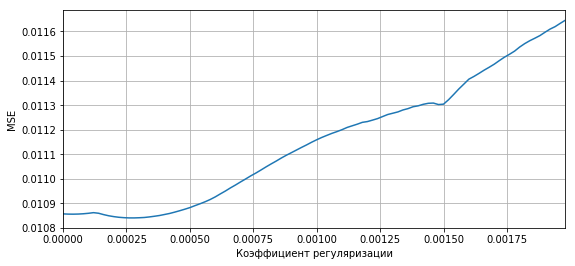

CPU times: user 17.4 s, sys: 354 ms, total: 17.8 s
Wall time: 17.8 s


In [111]:
%%time
build_plot(X_train, y_train, X_val, y_val)

In [135]:
regr = GradientLR(0.1, iterations=10000, l=0.00025)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 0.01084150194669796, R2: 0.691665433183726


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [140]:
print(f"Intercept: {regr.intercept_}\nCoefficients: {regr.coef_}")

Intercept: 0.29762499368024214
Coefficients: [-6.28524015e-02  7.46559699e-02 -2.08033465e-05  5.03701322e-02
 -9.29308773e-02  5.53627647e-01  1.39208249e-02 -2.19323908e-01
  1.07241254e-01 -1.31986857e-01 -1.56474686e-01  1.10167045e-01
 -3.88274833e-01]


  1. crim     per capita crime rate by town
  2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
  3. indus    proportion of non-retail business acres per town
  4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
  5. nox      nitric oxides concentration (parts per 10 million)
  6. rm       average number of rooms per dwelling
  7. age      proportion of owner-occupied units built prior to 1940
  8. dis      weighted distances to five Boston employment centres
  9. rad      index of accessibility to radial highways
10. tax      full-value property-tax rate per 10,000 dollars
 11. ptratio  pupil-teacher ratio by town
 12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 13. lstat    \% lower status of the population

`y`  medv     median value of owner-occupied homes in dollars

`Intercept=0.3` означает, что, если все фичи равны нулю, значение `y` равно 0.3.

Отрицательные коэффициенты говорят об уменьшении `y` с ростом фичи, положительные -- об увеличении. Так, фичи `crim`, `indus`, `nox`, `dis`, `tax`, `ptratio` и `lstat`своим ростом уменьшают значение медианной стоимости жилых домов, а остальные -- увеличивают. Более конкретно, например, с ростом показателя криминальности района на единицу стоимость жилых домов снижается на 0.06, с ростом концентрации nitric oxides на единицу стоимость жилья снижается на 0.09, а с ростом пропорции жилых домов, построенных до 1940, увеличивается на 0.01.